In [1]:
import pandas as pd
import numpy as np
from math import *
from sklearn import model_selection, metrics, dummy

import matplotlib.pyplot as plt

In [2]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, BayesianRidge
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

# Chargement des données

In [3]:
import pickle

with open("./data/pickle", 'rb') as f:
    data_X, data_Y = pickle.load(f)

In [4]:
# 0 pour les données sans star, 1 pour energystar
data_X = data_X[0]
data_Y = data_Y[0]

## Liste des colonnes utilisables

In [5]:
col_num = list(data_X.select_dtypes(include=['float', 'int', 'uint8']).columns)

# Prédiction simple

Pas de sélection, juste pour observer différents algos en CV (dont leur stabilité)

In [6]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LassoCV, MultiTaskLassoCV

In [7]:
def launch_kfold(model, X, y, splits=8, silence=False):
    kf = KFold(n_splits=splits)
    score_final = {'R2':0, 'RMSE':0, 'MAE':0}
    
    donnees_min = {'R2':1, 'iloc':None, 'pred':None}
    donnees_max = {'R2':-1, 'iloc':None, 'pred':None}

    for train, test in kf.split(X):
        # Entraînement
        model.fit(X.iloc[train], y.iloc[train])

        # Prédiction sur le jeu de test
        y_pred = model.predict(X.iloc[test])

        y_test = y.iloc[test]

        # Evaluate
        score = metrics.r2_score(y_test, y_pred)
        if not silence:
            print('R2 : ', score)
        score_final['R2'] += abs(score)
        
        if score < donnees_min['R2']:
            donnees_min['R2'] = score
            donnees_min['iloc'] = test.copy()
            donnees_min['pred'] = y_pred.copy()
        
        if score > donnees_max['R2']:
            donnees_max['R2'] = score
            donnees_max['iloc'] = test.copy()
            donnees_max['pred'] = y_pred.copy()

        score = metrics.mean_squared_error(y_test, y_pred, squared=True)
        score_final['RMSE'] += score

        score = metrics.mean_absolute_error(y_test.applymap(lambda x:max(0, x)), y_pred)
        score_final['MAE'] += score

    if not silence:
        for k, score in score_final.items():
            print('Score {} final : {}'.format(k, score/kf.get_n_splits()))
    
    return donnees_max, donnees_min

### Partie pour detecter les outliers réguliers
aka les lignes qui ne sont jamais bien prédites

In [8]:
def get_outliers(data_test, data_pred, outliers={}, step=0, limit=20):
    data_pred = pd.Series(data_pred, index=data_test.index).rename('Pred')

    compare_result = pd.concat([data_test.rename('Test'), data_pred], axis=1)
    compare_result['Diff'] = (compare_result['Test'] - compare_result['Pred']).abs()
    compare_result = compare_result.sort_values(by='Diff', ascending=False)
    
    for i in compare_result.head(limit).index:
        if i not in outliers:
            outliers[i] = 1-step
        else:
            outliers[i] += 1-step
    
    return outliers

In [9]:
outliers = {}

In [10]:
'''
for _ in range(50):
    idx = np.random.permutation(data_X.index)
    data_X = data_X.reindex(idx)
    data_Y = data_Y.reindex(idx)

    regr = XGBRegressor() #RandomForestRegressor(max_depth=50), XGBRegressor(), MultiTaskLassoCV(cv=5)
    donnees_max, donnees_min = launch_kfold(regr, data_X[col_num], data_Y['Energy_Y'], silence=True)
    print(donnees_min['R2'])
    if donnees_min['R2'] < 0.6 :
        outliers = get_outliers(data_Y.iloc[donnees_min['iloc'], 0], np.transpose(donnees_min['pred'])[0], outliers, step=donnees_min['R2'], limit=10)
'''

"\nfor _ in range(50):\n    idx = np.random.permutation(data_X.index)\n    data_X = data_X.reindex(idx)\n    data_Y = data_Y.reindex(idx)\n\n    regr = XGBRegressor() #RandomForestRegressor(max_depth=50), XGBRegressor(), MultiTaskLassoCV(cv=5)\n    donnees_max, donnees_min = launch_kfold(regr, data_X[col_num], data_Y['Energy_Y'], silence=True)\n    print(donnees_min['R2'])\n    if donnees_min['R2'] < 0.6 :\n        outliers = get_outliers(data_Y.iloc[donnees_min['iloc'], 0], np.transpose(donnees_min['pred'])[0], outliers, step=donnees_min['R2'], limit=10)\n"

In [11]:
# pd.DataFrame(outliers.items()).sort_values(by=1, ascending=False).head(20)

Suppression de ces valeurs

In [12]:
for i in []:#[304, 426, 3206]:
    data_X = data_X.drop(index=i)
    data_Y = data_Y.drop(index=i)

## Test de différents regressors

In [13]:
print('KFold avec DummyRegressor :')
dum = dummy.DummyRegressor(strategy='median')
launch_kfold(dum, data_X[col_num], data_Y)

print('\n'*3, 'KFold avec Lasso :')
regr = MultiTaskLassoCV(cv=5)
launch_kfold(regr, data_X[col_num], data_Y)

print('\n'*3, 'KFold avec XGBoost :')
xgbreg = XGBRegressor()
launch_kfold(xgbreg, data_X[col_num], data_Y)

print('\n'*3, 'KFold avec RandomForest :')
regr = RandomForestRegressor(max_depth=50)
donnees_max, donnees_min = launch_kfold(regr, data_X[col_num], data_Y)

KFold avec DummyRegressor :
R2 :  -0.005550055285828637
R2 :  -0.0018883401734924865
R2 :  -0.00991992176070422
R2 :  -0.0015297835709243701
R2 :  -0.014974090022305653
R2 :  -0.008035376734905286
R2 :  -0.028986033735451833
R2 :  -0.0032133959484093033
Score R2 final : 0.009262124654002724
Score RMSE final : 1.8733558654785156
Score MAE final : 1.0807838482003995



 KFold avec Lasso :
R2 :  0.6234086023023743
R2 :  0.69613252130143
R2 :  0.6379037992066234
R2 :  0.7291547801499141
R2 :  0.7520444044599461
R2 :  0.7341821588041499
R2 :  0.7094114422172759
R2 :  0.67128524192858
Score R2 final : 0.6941903687962867
Score RMSE final : 0.5713832818100079
Score MAE final : 0.5738869403815292



 KFold avec XGBoost :
R2 :  0.6693454015219837
R2 :  0.7145367052810068
R2 :  0.644859511728844
R2 :  0.730256481277983
R2 :  0.7486527609834014
R2 :  0.7442463205604231
R2 :  0.7414847138723846
R2 :  0.6993576526897685
Score R2 final : 0.7115924434894745
Score RMSE final : 0.5357333980500698
Score 

## Affichage des features importance

In [14]:
def get_features_importance(model, X, y, plot=False):
    model.fit(X, y)
    importance = model.feature_importances_

    list_col = X.columns.to_list()
    list_features = []
    for i, v in pd.Series(importance).sort_values(ascending=False).items():
        list_features.append([list_col[i],v])
    
    list_features = pd.DataFrame(list_features, columns=['Nom', 'Value'])
    
    if plot:
        list_features.head(20).plot.barh(x='Nom', y='Value', figsize=(7,7))
    
    return list_features

,Nom,Value
0,PropertyGFATotal,0.121802
1,Type_Self-storage facility,0.092426
2,Type_Supermarket/grocery store,0.080227
3,Type_Worship facility,0.053085
4,Type_Laboratory,0.041274
5,Type_Data center,0.036241
6,Type_Distribution center,0.034670
7,Type_Non-refrigerated warehouse,0.033552
8,Type_Fitness center/health club/gym,0.032184
9,Type_Restaurant,0.029722


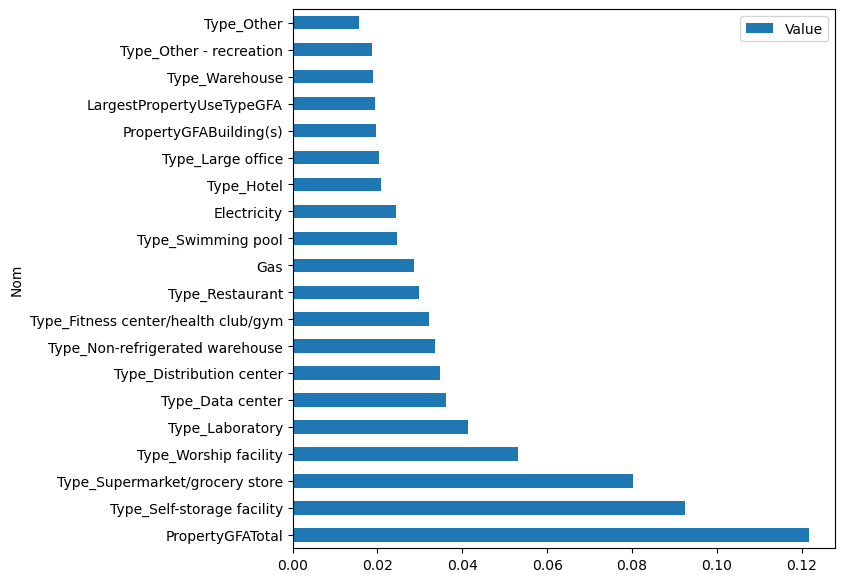

In [15]:
model = RandomForestRegressor(max_depth=30)
model = XGBRegressor()

get_features_importance(model, data_X[col_num], data_Y['Energy_Y'], True)

# GridSearch sur plusieurs algos

In [16]:
TARGET = 'Energy_Y' #'Energy_Y', 'CO2_Y'

In [17]:
from sklearn.model_selection import GridSearchCV
import time

list_models = []

def grid_search_cv_models(X, y, models, params):
    global list_models
    best_score = 0
    best_model = None
    
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.33)

    for model, model_params in zip(models, params):
        gs = GridSearchCV(model, model_params, cv=5, error_score='raise', refit='r2', scoring=['r2', 'neg_root_mean_squared_error', 'neg_mean_absolute_error'])
        
        # Entraîner le modèle sur les données X et y
        gs.fit(X_train, y_train)
        
        print("\n"*5, str(gs.best_estimator_), '\n')
        
        nom_estimator = str(gs.best_estimator_)
        
        list_models.append({"name":nom_estimator[:nom_estimator.index('(')], "clf":gs.best_estimator_})
        
        tab_cv_result = pd.DataFrame(gs.cv_results_)
        
        print(tab_cv_result[['mean_fit_time', 'mean_score_time', 'mean_test_r2']]) # 'params', 
        
        tab_cv_result = tab_cv_result.loc[tab_cv_result['rank_test_r2']==1]
        
        print("Temps d'entrainement : ", tab_cv_result['mean_fit_time'].to_list()[0])
        print("Temps de prédiction : ", tab_cv_result['mean_score_time'].to_list()[0])
        
        for n, m in [('R2', 'r2'), ('RMSE', 'neg_root_mean_squared_error'), ('MAE', 'neg_mean_absolute_error')]:
            mean = tab_cv_result['mean_test_'+m].to_list()[0]
            std = tab_cv_result['std_test_'+m].to_list()[0]
            
            if n!='R2':
                mean = -mean
                
            print("Score {} : {:.4f} Deviation : {:.4f}".format(n, mean, std))
        
        
        #print(tab_cv_result.columns)
        print('\nTest sur les données restantes :')
        
        start_time = time.time()
        trained_estimator = gs.best_estimator_.fit(X_train, y_train)
        print("Temps d'entrainement : ", time.time() - start_time)
        
        start_time = time.time()
        y_pred = trained_estimator.predict(X_test)
        print("Temps de prédiction : ", time.time() - start_time)
        
        for n, m in [('R2', metrics.r2_score),
                     ('RMSE', metrics.mean_squared_error),
                     ('MAE', metrics.mean_absolute_error)]:
            score = m(y_test, np.abs(y_pred))
            
            if n=='RMSE':
                score = sqrt(score)
            
            print("Score {} : {:.4f}".format(n, score))
        
        # Si le meilleur score de ce modèle est supérieur au meilleur score actuel, le mettre à jour
        if gs.best_score_ > best_score:
            best_score = gs.best_score_
            best_model = gs.best_estimator_
    # Renvoyer le meilleur modèle
    return best_model

In [18]:
# Une liste de modèles
models = [dummy.DummyRegressor(), KNeighborsRegressor(), LassoCV(), RandomForestRegressor(), Ridge(), LinearRegression(), Lasso(), BayesianRidge(), XGBRegressor()]
# Une liste de paramètres pour les modèles correspondants
params = [{'strategy':['mean', 'median']},
          {'n_neighbors':[5, 10, 15, 30], 'weights':['distance']},
          {'cv':[2, 3, 4, 5, 6, 8]},
          {"max_depth": [3, 5, 10, 20, 30, 50, 75, 100]},
          {"alpha": np.arange(0.1, 0.9, 0.01)},
          {},
          {"alpha": np.arange(0.1, 0.9, 0.01)},
          {'alpha_init':[1, 1.4, 1.9],
           'lambda_init': [1e-1, 1e-3, 1e-5]},
          {"learning_rate": [0.10, 0.15],
            "max_depth": [3, 5],
            "min_child_weight": [2, 3, 4],
            "gamma":[0.0, 0.05],
            "colsample_bytree":[0.3, 0.4]}]


best_model = grid_search_cv_models(data_X[col_num], data_Y[TARGET], models, params)
print("Le meilleur modèle est:", best_model)






 DummyRegressor() 

   mean_fit_time  mean_score_time  mean_test_r2
0       0.000000              0.0     -0.012552
1       0.003131              0.0     -0.026013
Temps d'entrainement :  0.0
Temps de prédiction :  0.0
Score R2 : -0.0126 Deviation : 0.0080
Score RMSE : 1.2805 Deviation : 0.0417
Score MAE : 1.0262 Deviation : 0.0333

Test sur les données restantes :
Temps d'entrainement :  0.0
Temps de prédiction :  0.0
Score R2 : -0.0000
Score RMSE : 1.3122
Score MAE : 1.0531





 KNeighborsRegressor(n_neighbors=10, weights='distance') 

   mean_fit_time  mean_score_time  mean_test_r2
0       0.003124         0.105829      0.621083
1       0.002410         0.085435      0.627043
2       0.007631         0.082259      0.624555
3       0.000402         0.090256      0.608323
Temps d'entrainement :  0.002410125732421875
Temps de prédiction :  0.08543472290039063
Score R2 : 0.6270 Deviation : 0.0510
Score RMSE : 0.7762 Deviation : 0.0678
Score MAE : 0.5843 Deviation : 0.0470

Test su

## Analyse et comparaison des algos
avec les meilleurs hypermarametres sélectionnés

In [19]:
def setup_plot():
    plt.rcParams["axes.grid.axis"] ="y"
    plt.rcParams["axes.grid"] = True
    plt.rcParams["legend.fontsize"] = 14
    plt.rc('grid', linestyle="dashed", color='lightgrey', linewidth=1)
    plt.rcParams["xtick.labelsize"] = 15
    plt.rcParams["ytick.labelsize"]  = 15 

In [20]:
from sklearn.ensemble import VotingRegressor

tmp_reg = []
for e in list_models:
    if e['name'] in ['BayesianRidge', 'LassoCV', 'XGBRegressor']:
        tmp_reg.append((e['name'], e['clf']))

reg = VotingRegressor(estimators=tmp_reg)
list_models.append({'name':'Voting-Bay-Lasso-XGB', 'clf':reg})

name
DummyRegressor           0.000000
LinearRegression         0.401550
KNeighborsRegressor      0.632900
Lasso                    0.644818
Ridge                    0.707049
RandomForestRegressor    0.714947
LassoCV                  0.719307
BayesianRidge            0.720585
Voting-Bay-Lasso-XGB     0.741636
XGBRegressor             0.749581
Name: test_accuracy, dtype: float64


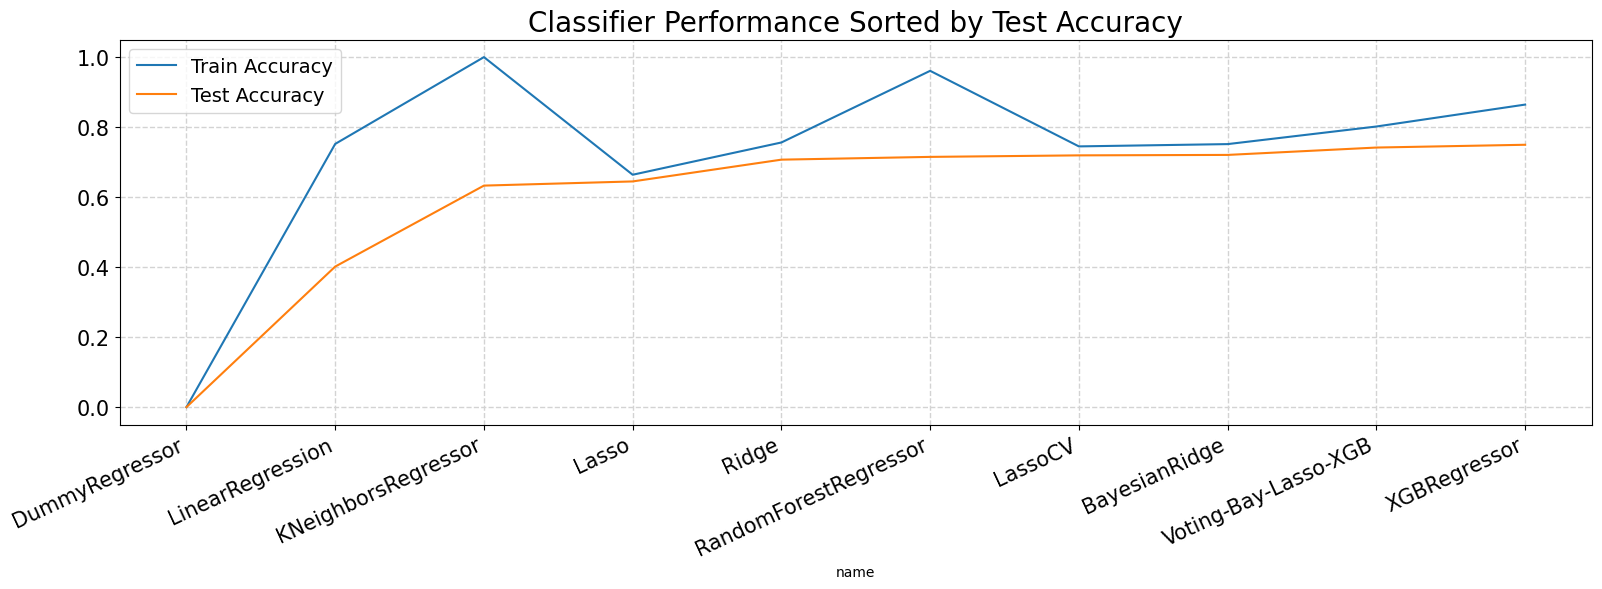

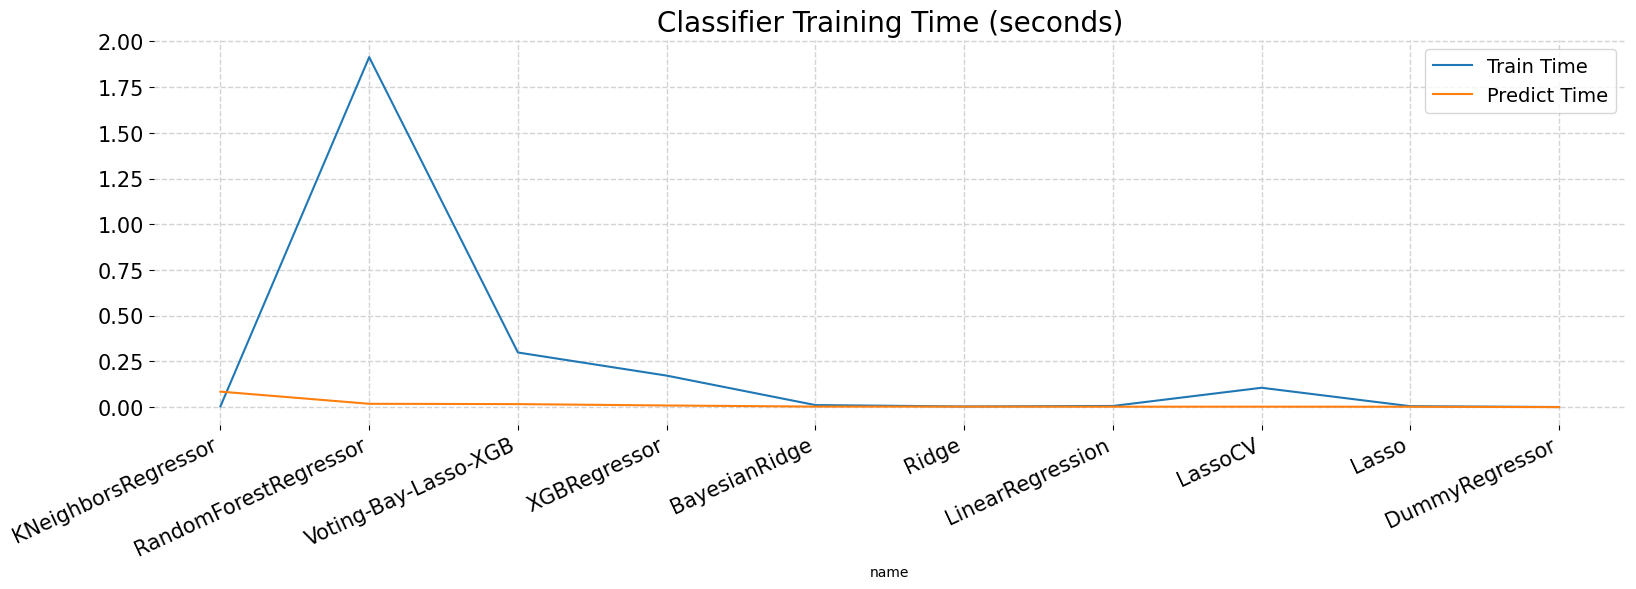

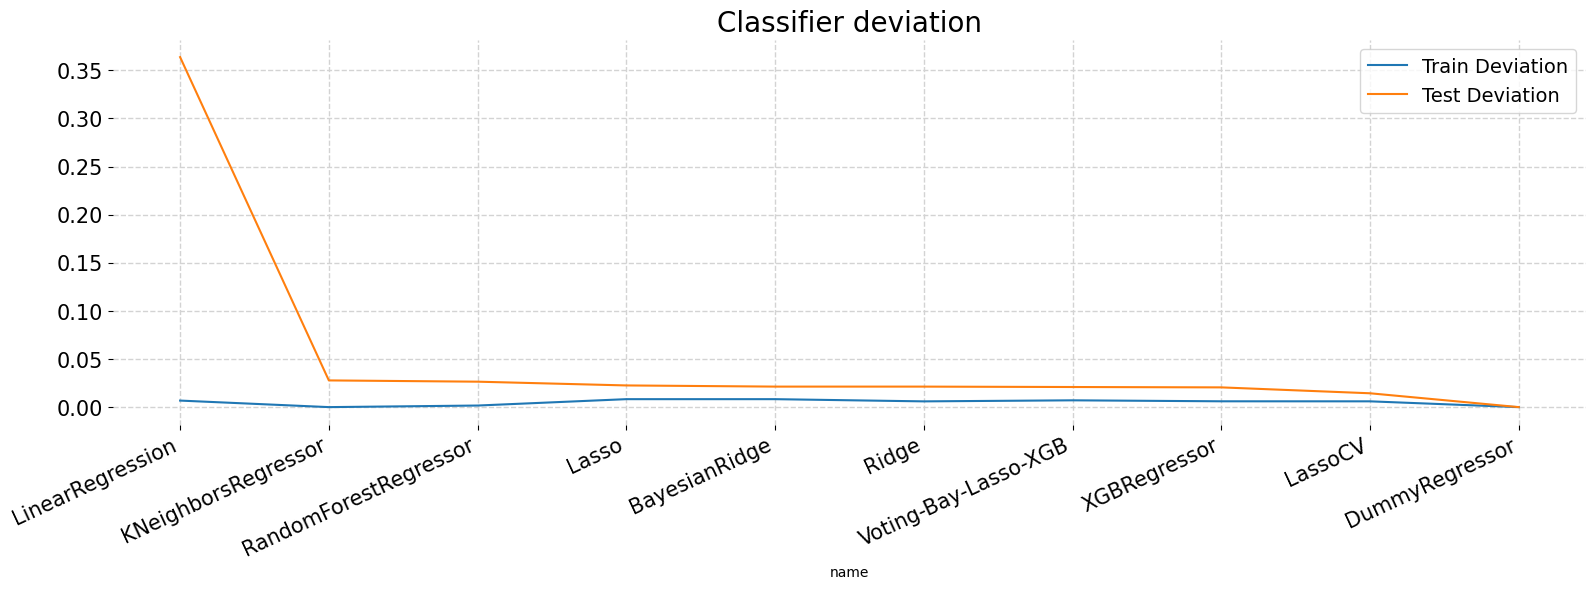

In [21]:
import time
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

trained_models = [] #  keep track of all details for models we train
def train_model(model, data, labels): 
    X = data
    y = labels
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    
    start_time = time.time()
    trained_model = model["clf"].fit(X_train, y_train)
    train_time = time.time() - start_time

    #mask_non_res = X_test[['BuildingType_Nonresidential', 'BuildingType_Nonresidential cos', 'BuildingType_Nonresidential wa']].sum(axis=1) == 1
    #X_test = X_test.loc[mask_non_res]
    #y_test = y_test.loc[mask_non_res]

    start_time = time.time()
    y_pred = trained_model.predict(X_test)
    predict_time = time.time() - start_time
    
    test_score = metrics.r2_score(y_test, y_pred)
    test_score = max(test_score, 0)
    
    y_pred = trained_model.predict(X_train)
    train_score = metrics.r2_score(y_train, y_pred)
    train_score = max(train_score, 0)
    
    model_details = {"name": model["name"], "test_accuracy": test_score, "train_accuracy": train_score, "train_time": train_time, "predict_time": predict_time}
    return model_details

models = [
          {"name": "Dummy Regressor", "clf": dummy.DummyRegressor()},
          {"name": "KNN", "clf": KNeighborsRegressor(n_neighbors=10, weights='distance')},
          {"name": "LassoCV", "clf": LassoCV(cv=50)}, 
          {"name": "Lasso", "clf": Lasso(alpha=0.1)},
          {"name": "RandomForestRegressor", "clf": RandomForestRegressor(max_depth=75)},
          {"name": "Ridge", "clf": Ridge(alpha=0.89)}, 
          {"name": "LinearRegression", "clf": LinearRegression()}, 
          {"name": "BayesianRidge", "clf": BayesianRidge()},
          {"name": "Best Model", "clf": best_model}]

for model in list_models*25:
    model_details = train_model(model, data_X[col_num], data_Y[TARGET]) 
    trained_models.append(model_details)


    
# visualize accuracy and run time
setup_plot()
model_df = pd.DataFrame(trained_models).groupby('name').mean()
model_df.sort_values("test_accuracy", inplace=True)
print(model_df["test_accuracy"])
ax = model_df[["train_accuracy","test_accuracy"]].plot(kind="line", figsize=(19,5), title="Classifier Performance Sorted by Test Accuracy")
ax.legend(["Train Accuracy", "Test Accuracy"])
ax.title.set_size(20)
ax.set_xticks(range(len(model_df)), model_df.index.to_list(), rotation=25, ha='right')
#plt.xticks(rotation=90)

model_df.sort_values("predict_time", inplace=True, ascending=False)
ax= model_df[["train_time", "predict_time"]].plot(kind="line", figsize=(19,5), grid=True, title="Classifier Training Time (seconds)")
ax.title.set_size(20)
ax.legend(["Train Time", "Predict Time"])
ax.set_xticks(range(len(model_df)), model_df.index.to_list(), rotation=25, ha='right')
plt.box(False)  


model_df = pd.DataFrame(trained_models).groupby('name').std()
model_df.sort_values("test_accuracy", inplace=True, ascending=False)
ax= model_df[["train_accuracy","test_accuracy"]].plot(kind="line", figsize=(19,5), grid=True, title="Classifier deviation")
ax.title.set_size(20)
ax.legend(["Train Deviation", "Test Deviation"])
ax.set_xticks(range(len(model_df)), model_df.index.to_list(), rotation=25, ha='right')
plt.box(False) 

In [22]:
import shap

In [23]:
shap.initjs()

In [24]:
shap_model = BayesianRidge(alpha_init=1, lambda_init=0.1)#LassoCV(cv=5)
shap_model.fit(data_X[col_num], data_Y[TARGET])

explainer = shap.Explainer(shap_model, data_X[col_num], feature_names=col_num)
shap_values = explainer.shap_values(data_X[col_num])

In [25]:
#shap_model = XGBRegressor().fit(data_X[col_num], data_Y[TARGET])

In [26]:
#explainer = shap.Explainer(shap_model, feature_names=col_num)
#shap_values = explainer.shap_values(data_X[col_num])

In [27]:
shap.force_plot(explainer.expected_value, shap_values[0], feature_names=col_num)

In [28]:
#shap.plots.waterfall(shap_values[0])

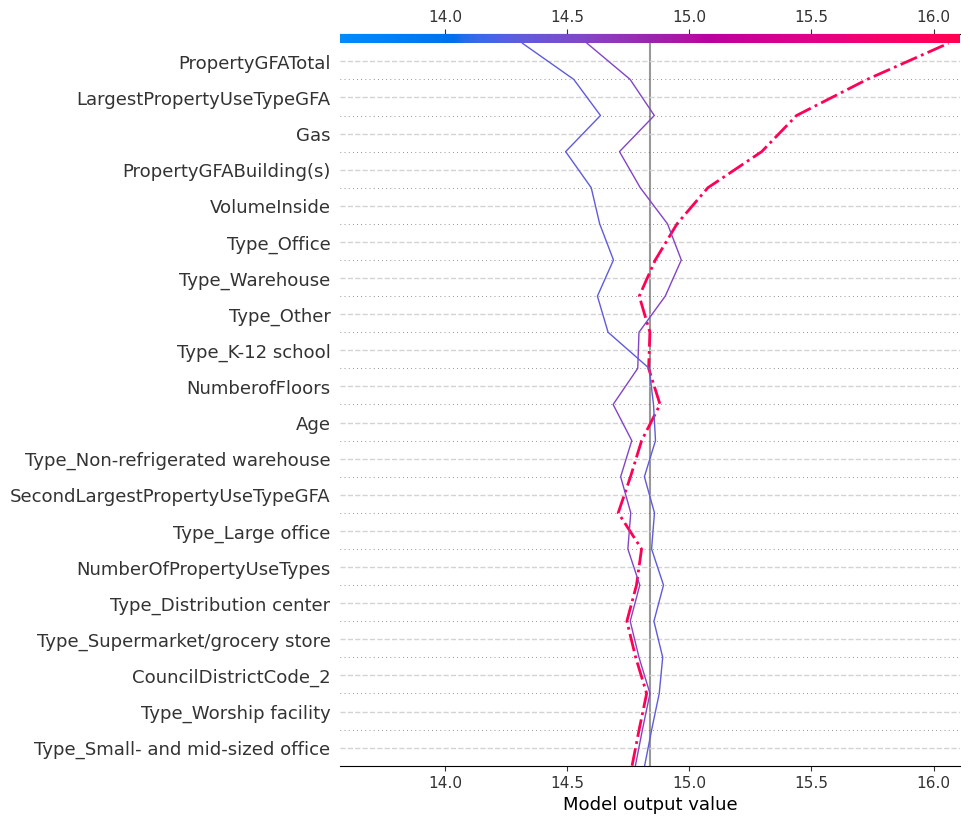

In [29]:
shap.decision_plot(explainer.expected_value, shap_values[0:3], col_num, highlight=0)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


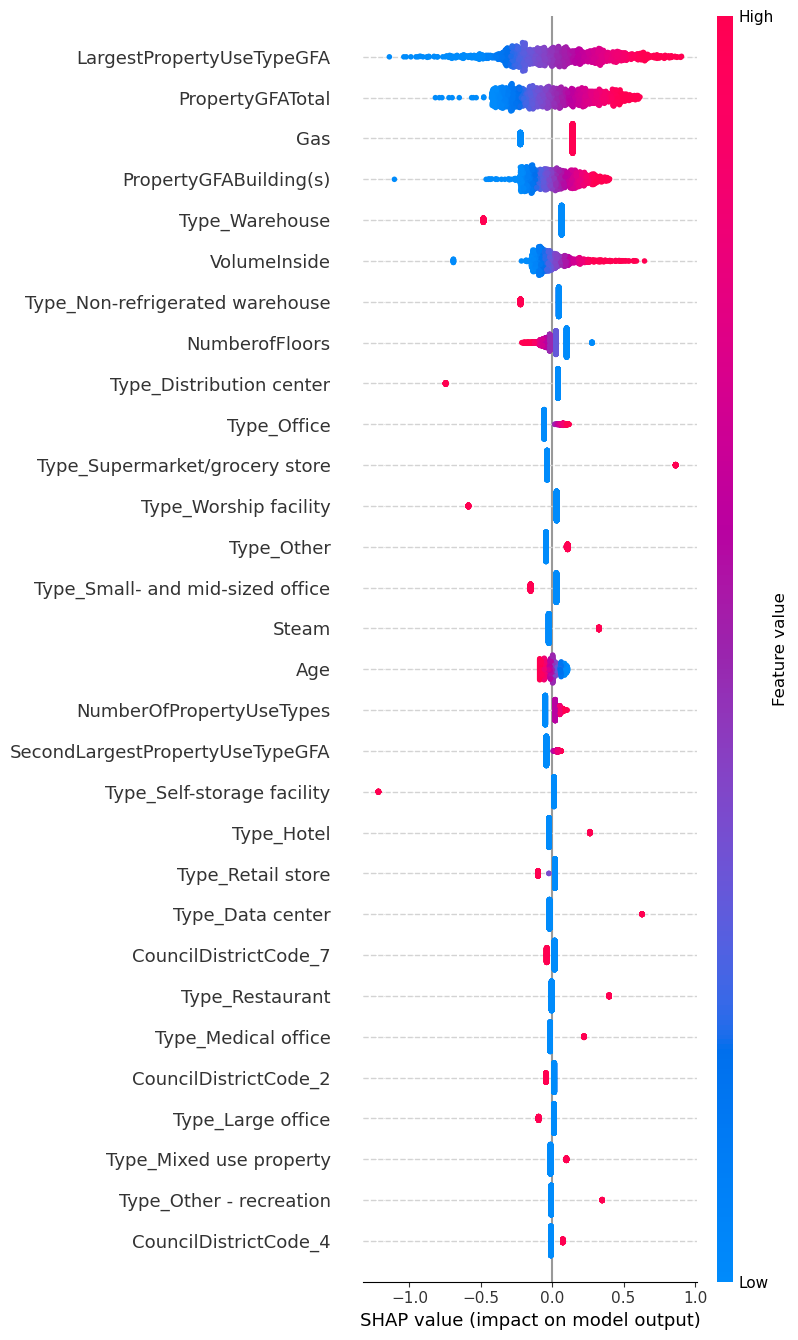

In [30]:
shap.summary_plot(shap_values, data_X[col_num], max_display=30)

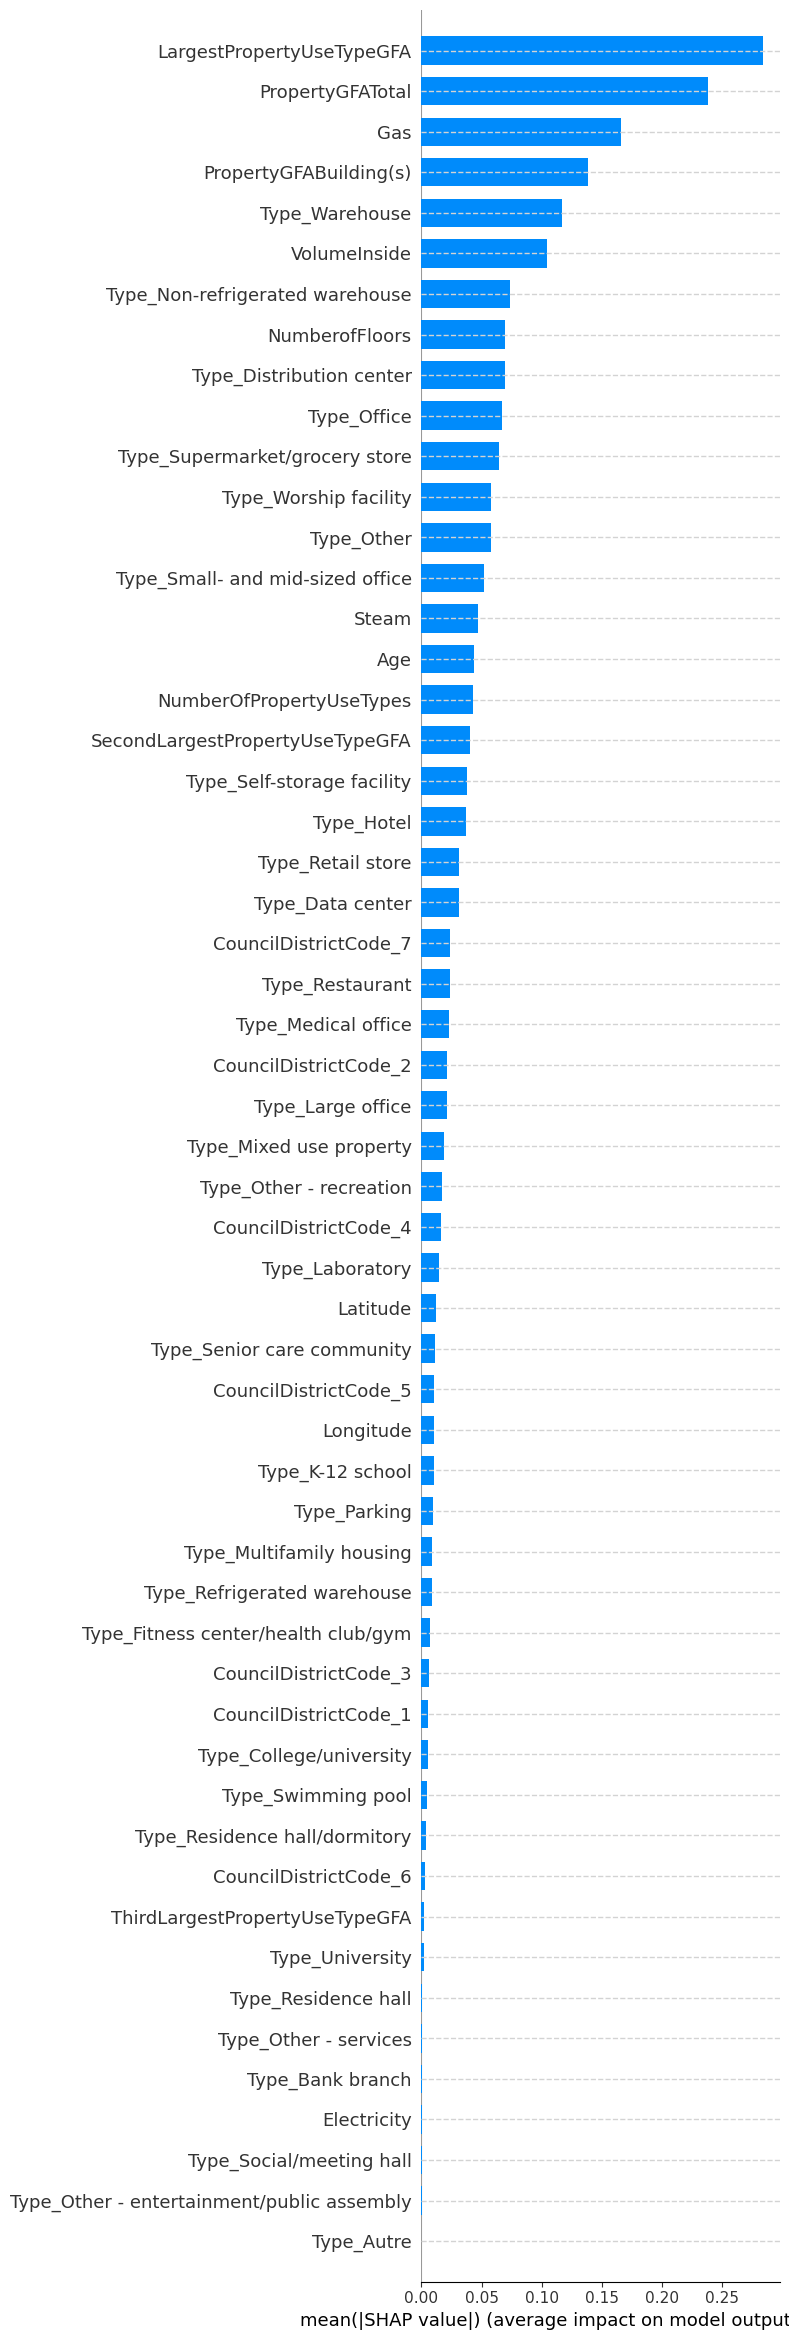

In [31]:
shap.summary_plot(shap_values, data_X[col_num], plot_type="bar", max_display=300)

In [32]:
output = 'Energy_Y'
algo = 'XGB'

In [33]:
y_hist = pd.DataFrame(columns=['Test', 'Predict'])

In [34]:
kf = KFold(n_splits=8)

for train, test in kf.split(data_X):
    X_train, y_train = data_X[col_num].iloc[train], data_Y[output].iloc[train]
    X_test, y_test = data_X[col_num].iloc[test], data_Y[output].iloc[test]
    
    model = BayesianRidge(alpha_init=1, lambda_init=0.1)
    if algo == 'XGB':
        model = XGBRegressor()
    model.fit(X_train, y_train)
    y_predict = pd.Series(model.predict(X_test), index=y_test.index)
    
    y_hist_tmp = pd.concat([y_test, y_predict], axis=1)
    y_hist_tmp.columns=['Test', 'Predict']
    
    y_hist = pd.concat([y_hist, y_hist_tmp])

In [35]:
y_hist['Diff'] = np.log(np.abs(np.exp(y_hist['Test'])-np.exp(y_hist['Predict'])))

In [36]:
y_hist

,Test,Predict,Diff
3158,17.519617,15.957497,17.284286
1997,13.538452,14.284050,13.640739
2225,14.057712,14.560760,13.632688
968,14.425904,14.095054,13.158948
1950,13.962186,14.592827,13.833004
...,...,...,...
1326,12.986784,13.307166,12.013007
1573,14.517602,14.250834,13.065807
158,17.888994,17.514769,16.724813
2518,14.719958,15.252563,14.368075


In [37]:
import seaborn as sns

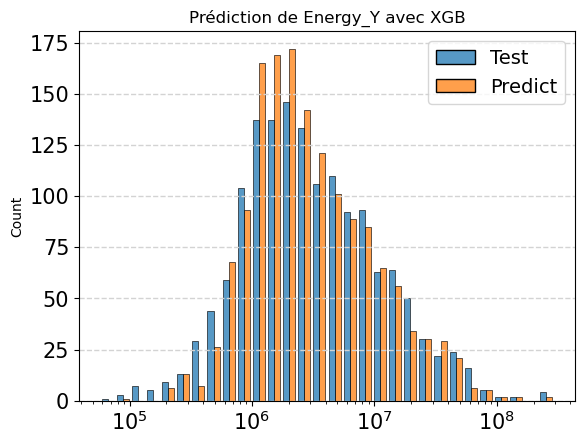

In [38]:
ax = sns.histplot(np.exp(y_hist[['Test', 'Predict']]), multiple="dodge", shrink=.8, log_scale=(True, False), bins=30)
ax.set(title="Prédiction de {} avec {}".format(output, algo))

fig = ax.get_figure()
fig.savefig("./data/graph/predict_{}_{}.png".format(output, algo)) 

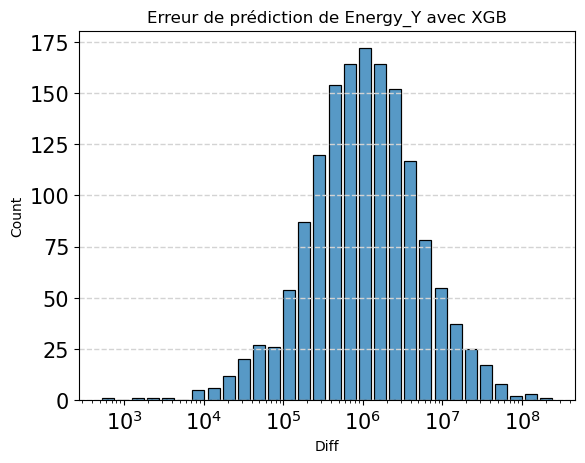

In [39]:
ax = sns.histplot(np.exp(y_hist['Diff']), shrink=.8, log_scale=(True, False), bins=30)
ax.set(title="Erreur de prédiction de {} avec {}".format(output, algo))

fig = ax.get_figure()
fig.savefig("./data/graph/erreur_{}_{}.png".format(output, algo)) 

<AxesSubplot: xlabel='Test', ylabel='Predict'>

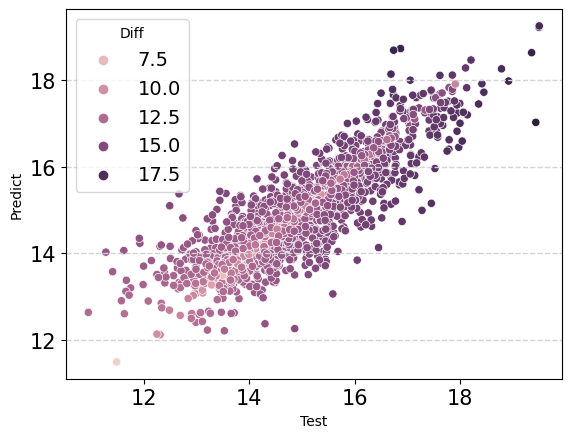

In [40]:
sns.scatterplot(y_hist, x='Test', y='Predict', hue='Diff')

In [41]:
annee_tranform = [(i, i*0.0334408 - 2.2) for i in range(0, 200, 5)]

In [42]:
model = BayesianRidge(alpha_init=1, lambda_init=0.1)
model.fit(data_X[col_num], data_Y['CO2_Y'])

BayesianRidge(alpha_init=1, lambda_init=0.1)

In [43]:
data_X_modif = data_X.loc[[1], col_num]

In [44]:
data_X.loc[[1], 'Age']

1   -1.058339
Name: Age, dtype: float64

In [45]:
for i, i_pt in annee_tranform:
    data_X_modif_tmp = data_X_modif.copy()
    data_X_modif_tmp['Age'] = i_pt
    print(i, np.exp(model.predict(data_X_modif_tmp)[0]))

0 336.10008111292757
5 336.2151148718365
10 336.3301880022494
15 336.4453005176416
20 336.5604524314927
25 336.67564375728796
30 336.790874508516
35 336.9061446986705
40 337.0214543412504
45 337.1368034497583
50 337.2521920377016
55 337.3676201185932
60 337.4830877059496
65 337.5985948132919
70 337.71414145414707
75 337.8297276420454
80 337.945353390522
85 338.0610187131175
90 338.1767236233763
95 338.29246813484735
100 338.4082522610851
105 338.524076015648
110 338.63993941209884
115 338.75584246400604
120 338.87178518494187
125 338.9877675884831
130 339.1037896882122
135 339.21985149771524
140 339.335953030583
145 339.45209430041194
150 339.56827532080194
155 339.6844961053582
160 339.80075666769034
165 339.91705702141246
170 340.0333971801442
175 340.1497771575089
180 340.2661969671346
185 340.3826566226549
190 340.49915613770725
195 340.6156955259336


In [46]:
np.exp(data_Y.loc[[1]])

,Energy_Y,CO2_Y
1,8387932.5,296.860016
